<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/01-Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git

In [1]:
import os
os.environ["EQX_ON_ERROR"] = "nan"
import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint , cic_paint_dx
from jaxpm.pm import linear_field, lpt, make_ode_fn

In [2]:
mesh_shape = [256, 256, 256]
box_size = [256., 256., 256.]
snapshots = jnp.linspace(0.1,1.,2)

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1 , 3])
    # Create particles
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)
    
    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape,particles), [particles + dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)
    
    # Return the simulation volume at requested 

    return initial_conditions ,  particles + dx , res[0]

In [4]:
initial_conditions , lpt_particles , ode_particles = run_simulation(0.25, 0.8)
%timeit initial_conditions , lpt_particles , ode_particles = run_simulation(0.25, 0.8)

3.31 s ± 545 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


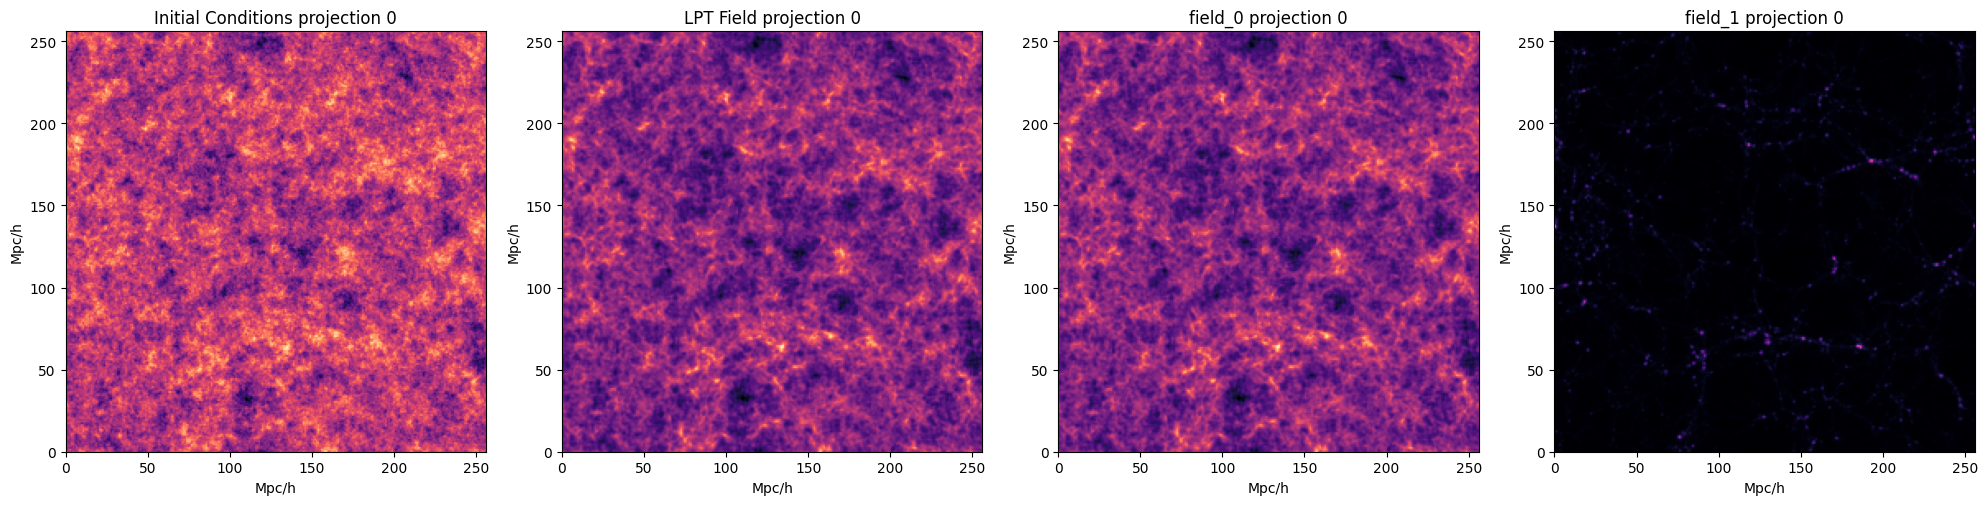

In [5]:
from visualize import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint(jnp.zeros(mesh_shape) ,lpt_particles)}
for i , field in enumerate(ode_particles):
    fields[f"field_{i}"] = cic_paint(jnp.zeros(mesh_shape) , field)
plot_fields_single_projection(fields)

In [6]:
mesh_shape = [256, 256, 256]
box_size = [256., 256., 256.]
snapshots = jnp.linspace(0.1,1.,2)

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, a=0.1)
    
    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape), [dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)
    
    # Return the simulation volume at requested 

    return initial_conditions ,  dx , res[0]
    
initial_conditions , lpt_displacements , ode_displacements = run_simulation(0.25, 0.8)
%timeit initial_conditions , lpt_displacements , ode_displacements = run_simulation(0.25, 0.8)

5.79 s ± 926 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


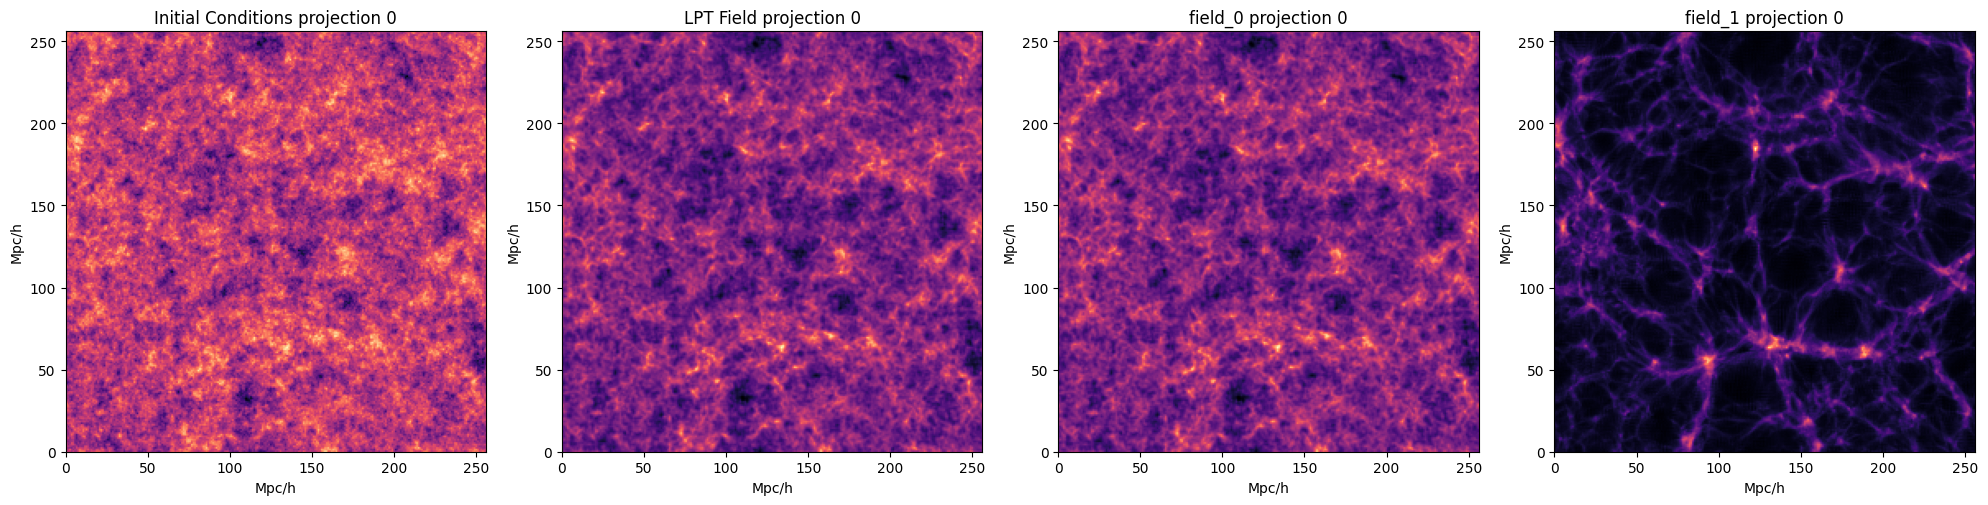

In [7]:
from visualize import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint_dx(lpt_displacements)}
for i , field in enumerate(ode_displacements):
    fields[f"field_{i}"] = cic_paint_dx(field)
plot_fields_single_projection(fields)

In [8]:
!pip install diffrax
from diffrax import ConstantStepSize, LeapfrogMidpoint, ODETerm, SaveAt, diffeqsolve

In [9]:
mesh_shape = [256, 256, 256]
box_size = [256., 256., 256.]
snapshots = jnp.linspace(0.1,1.,2)

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, a=0.1)
    
    # Evolve the simulation forward
    ode_fn = make_ode_fn(mesh_shape)
    term = ODETerm(
        lambda t, state, args: jnp.stack(ode_fn(state, t, args), axis=0))
    solver = LeapfrogMidpoint()

    stepsize_controller = ConstantStepSize()
    res = diffeqsolve(term,
                      solver,
                      t0=0.1,
                      t1=1.,
                      dt0=0.01,
                      y0=jnp.stack([dx, p], axis=0),
                      args=cosmo,
                      saveat=SaveAt(ts=snapshots),
                      stepsize_controller=stepsize_controller)


    return initial_conditions ,  dx , res.ys , res.stats

initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8)
%timeit initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8)
print(f"Solver Stats : {solver_stats}")

4.03 s ± 433 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Solver Stats : {'max_steps': Array(4096, dtype=int32, weak_type=True), 'num_accepted_steps': Array(90, dtype=int32, weak_type=True), 'num_rejected_steps': Array(0, dtype=int32, weak_type=True), 'num_steps': Array(90, dtype=int32, weak_type=True)}


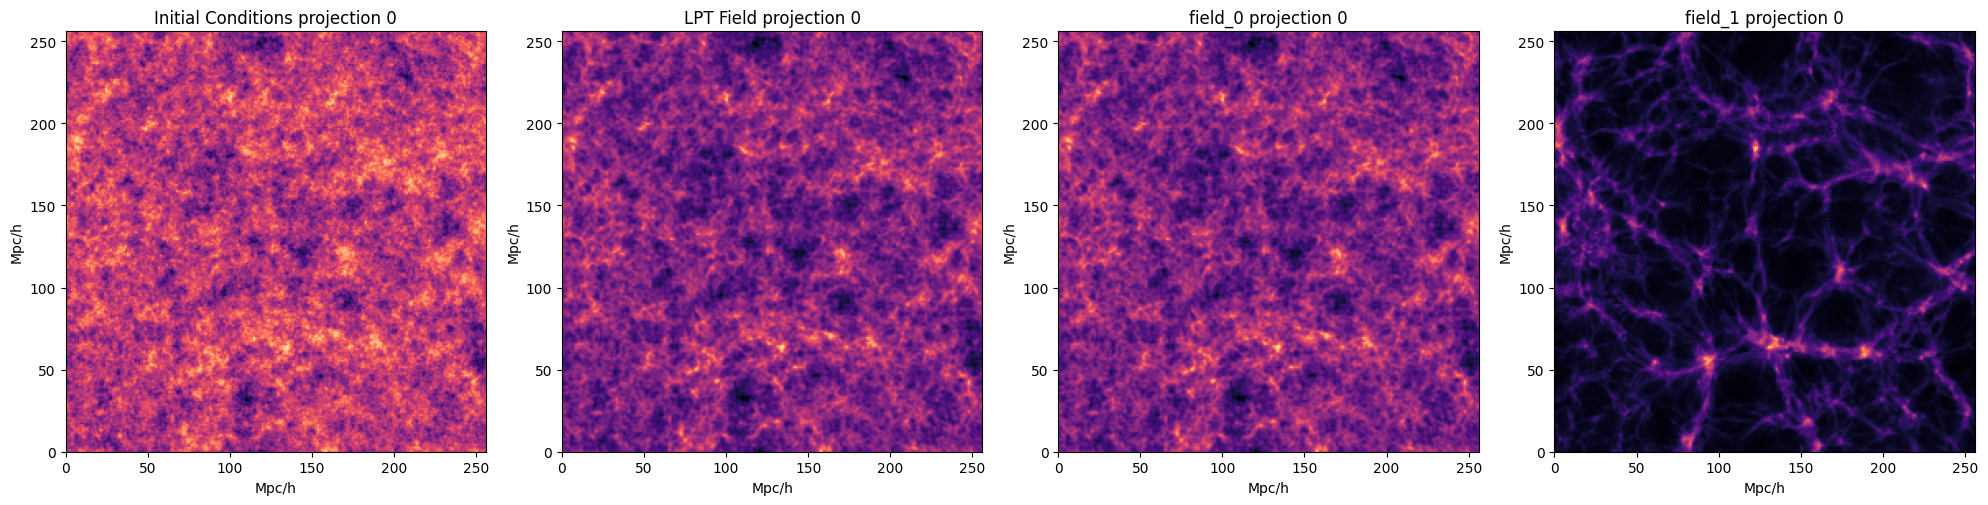

In [10]:
from visualize import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint_dx(lpt_displacements)}
for i , field in enumerate(ode_solutions):
    fields[f"field_{i}"] = cic_paint_dx(field[0])
plot_fields_single_projection(fields)

In [11]:
mesh_shape = [256, 256, 256]
box_size = [256., 256., 256.]
snapshots = jnp.linspace(0.1,1.,2)

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, a=0.1,order=2)
    
    # Evolve the simulation forward
    ode_fn = make_ode_fn(mesh_shape)
    term = ODETerm(
        lambda t, state, args: jnp.stack(ode_fn(state, t, args), axis=0))
    solver = LeapfrogMidpoint()

    stepsize_controller = ConstantStepSize()
    res = diffeqsolve(term,
                      solver,
                      t0=0.1,
                      t1=1.,
                      dt0=0.01,
                      y0=jnp.stack([dx, p], axis=0),
                      args=cosmo,
                      saveat=SaveAt(ts=snapshots),
                      stepsize_controller=stepsize_controller)


    return initial_conditions ,  dx , res.ys , res.stats

initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8)
%timeit initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8)
print(f"Solver Stats : {solver_stats}")

4.03 s ± 150 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Solver Stats : {'max_steps': Array(4096, dtype=int32, weak_type=True), 'num_accepted_steps': Array(90, dtype=int32, weak_type=True), 'num_rejected_steps': Array(0, dtype=int32, weak_type=True), 'num_steps': Array(90, dtype=int32, weak_type=True)}


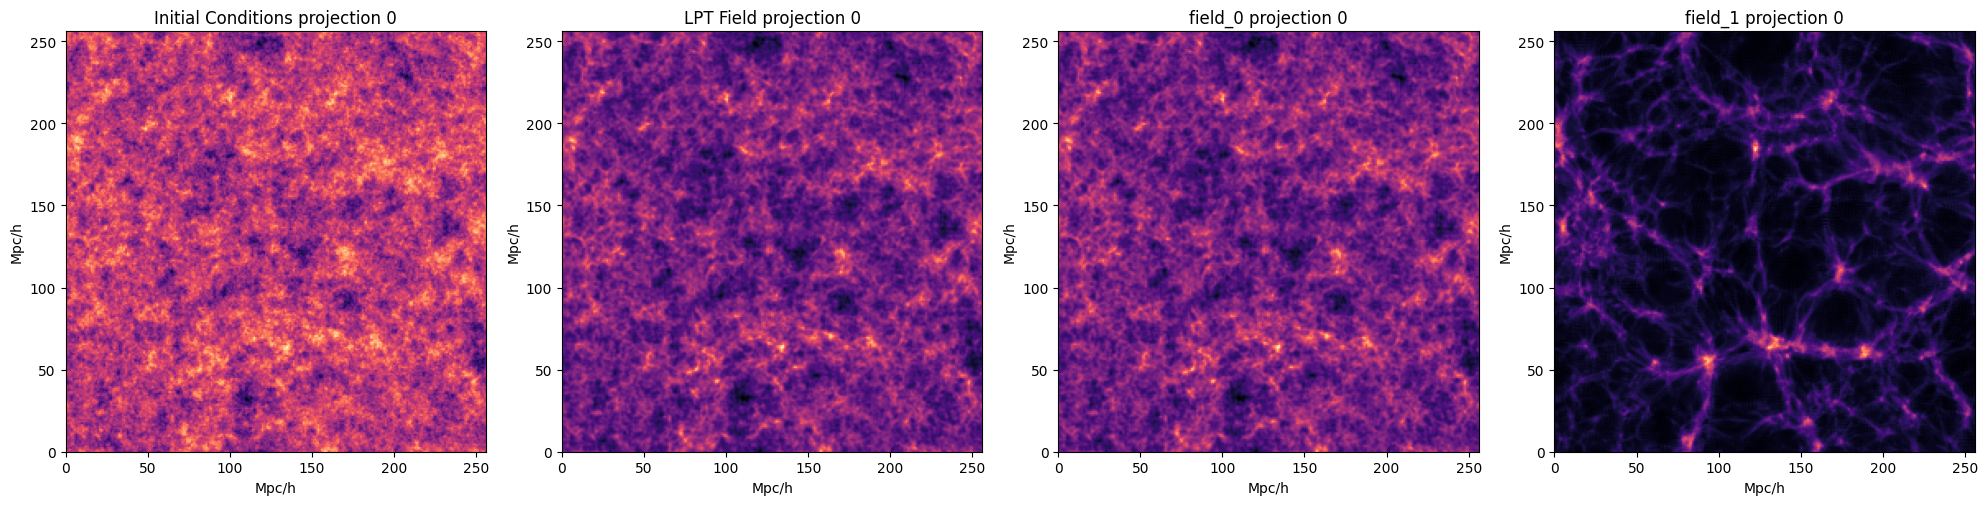

In [12]:
from visualize import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint_dx(lpt_displacements)}
for i , field in enumerate(ode_solutions):
    fields[f"field_{i}"] = cic_paint_dx(field[0])
plot_fields_single_projection(fields)